In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from patsy import dmatrices
pd.options.mode.chained_assignment = None

from sklearn import preprocessing

from sklearn.metrics import accuracy_score, roc_curve, auc, classification_report, confusion_matrix

from sklearn.cross_validation import cross_val_score, train_test_split
from sklearn.learning_curve import learning_curve
from sklearn.grid_search import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from __future__ import division
import pprint
import pickle
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix
import dateutil
from sklearn.metrics import roc_curve, auc
%matplotlib inline

In [2]:
df = pd.DataFrame(pickle.load(open('clean_data.pkl', 'rb')))

In [3]:
df.head()


,_projectid,_teacher_acctid,_schoolid,school_state,school_metro,school_district,school_charter,school_magnet,school_year_round,school_nlns,...,optional_support,per_optional_support,month,quarter,teacher_previous_success,school_previous_success,teacher_previous_projects,school_previous_projects,teacher_per_success,school_per_success
619508,1ca982c112cd2c333b15ee9836d789ef,8f7c1db86433c1bb367407a96c4c2d92,b96ce92e601ddb001fc7e130f175f263,NY,urban,New York City Dept Of Ed,f,f,f,f,...,1,0.176467,1,1,1,146,1,146,1,1
619626,d307b7953ef6932dc0d5f053a17a472f,1053ec5f182cf3d0ec5944123de4d1d7,d945e2fed811024a7323407e222a6a64,ME,rural,Aos 43,f,f,f,f,...,1,0.176457,1,1,38,53,38,53,1,1
619388,5c524c9e9f583569bf64efed8edcd847,a537f1c9f862ca3992bab5a79c1ae868,3264a9d682b91e4801f148eb6cae6a7c,CA,urban,Los Angeles Unif Sch Dist,f,f,f,f,...,1,0.176466,1,1,43,297,43,297,1,1
619498,1449db2dbaf7f018dd86e4e5a28b27a5,7bd92da677bb1fab60eae4780fab4018,d9004a7301bd8e468980401ef095104d,NC,urban,Charlotte-mecklenburg Sch Dist,f,f,f,f,...,1,0.176494,1,1,3,76,3,76,1,1
619664,a512a6db199668c6a6a4f23712b4735b,55634015e20f2eb4f4328131fa618fa2,977652f8265e85039d38d6c732df9278,NC,urban,Durham Public School District,f,f,f,f,...,1,0.176458,1,1,3,26,3,26,1,1


In [4]:
y, X = dmatrices(
    'RESP ~ primary_focus_area + primary_focus_subject + np.log(total_price_including_optional_support + np.sqrt(students_reached))',
    data=df, return_type='dataframe')
y = np.ravel(y)

std_scale = preprocessing.StandardScaler().fit(X)
X = std_scale.transform(X)

x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=7)

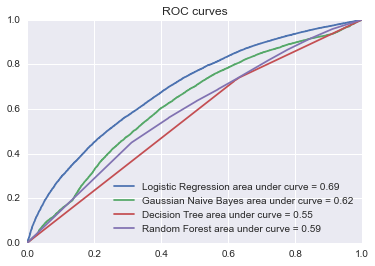

In [12]:
def curves(name, classifier):
    probas_ = classifier.fit(x_train, y_train).predict_proba(x_test)
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label = "%s area under curve = %0.2f" 
             % (name, roc_auc_score(y_test, probas_[:, 1])))
    plt.legend(loc = "best")
    plt.title("ROC curves")
    
#curves("KNN", KNeighborsClassifier())
curves("Logistic Regression", LogisticRegression())
curves("Gaussian Naive Bayes", GaussianNB())
#curves("SVM Classifier", SVC(probability = True))
curves("Decision Tree", DecisionTreeClassifier())
curves("Random Forest", RandomForestClassifier())

In [ ]:
sklearn.metrics.confusion_matrix

In [5]:
y, X = dmatrices('RESP ~ school_state+school_charter+school_magnet+ school_year_round+ school_nlns+ school_kipp+ school_charter_ready_promise+ teacher_prefix+teacher_teach_for_america+teacher_ny_teaching_fellow+primary_focus_subject+primary_focus_area+resource_type+poverty_level+grade_level+total_price_including_optional_support+students_reached+optional_support+quarter', data=df, return_type='dataframe')

y = np.ravel(y)

x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=7)

std_scale = preprocessing.StandardScaler().fit(x_train)
x_train = std_scale.transform(x_train)
x_test = std_scale.transform(x_test)

In [ ]:
def test_model(name, main_model):
    model = main_model
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    print name, "test accuracy score:", accuracy_score(y_test, model.predict(x_test))
    
test_model("KNN", KNeighborsClassifier())
test_model("Logistic Regression", LogisticRegression())
test_model("Gaussian Naive Bayes", GaussianNB())
test_model("SVM Classifier", SVC())
test_model("Decision Tree", DecisionTreeClassifier())
test_model("Random Forest", RandomForestClassifier())

In [ ]:
names, accs = [], []
for algorithm in (LogisticRegression, 
                 KNeighborsClassifier, 
                 GaussianNB,
                 DecisionTreeClassifier, 
                 RandomForestClassifier):
    accuracy = np.mean(cross_val_score(algorithm(), X, y, cv = 2))
    print '%-30s %0.4f' % (algorithm.__name__, accuracy)
    names.append(algorithm.__name__)
    accs.append(accuracy)

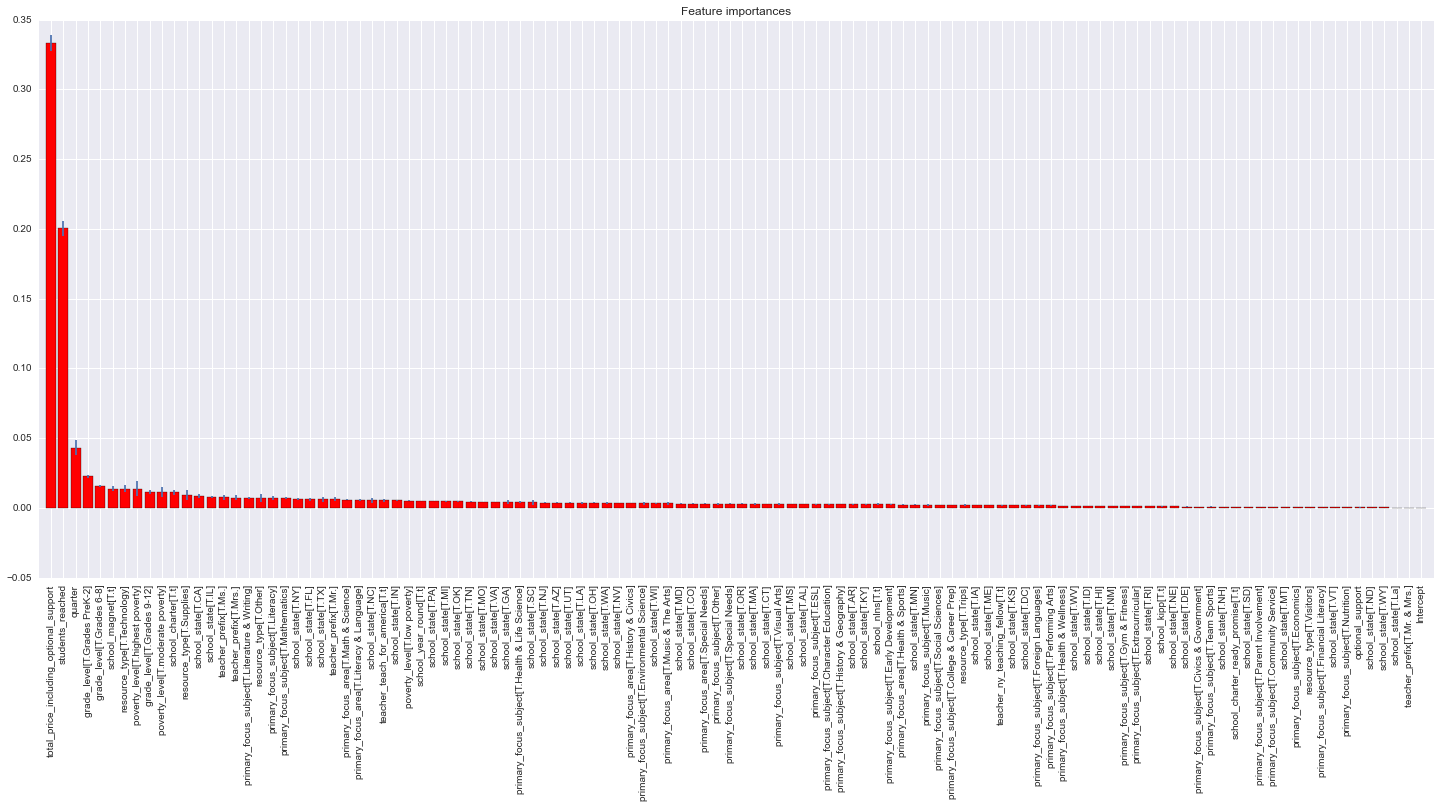

In [6]:
model = RandomForestClassifier()
model.fit(x_train, y_train)
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

plt.figure(figsize = (25,10))
plt.title("Feature importances")
plt.bar(range(len(indices)), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(len(indices)), X.columns[indices], rotation = 90)
plt.xlim([-1, len(indices)])
plt.show()

In [ ]:
y, X = dmatrices('RESP ~ school_state+school_charter+school_magnet+ school_year_round+ school_nlns+ school_kipp+ school_charter_ready_promise+ teacher_prefix+teacher_teach_for_america+teacher_ny_teaching_fellow+primary_focus_subject+primary_focus_area+resource_type+poverty_level+grade_level+total_price_including_optional_support+students_reached+optional_support+quarter+teacher_previous_success+school_previous_success', data=df2, return_type='dataframe')

y = np.ravel(y)

x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=7)

scale = preprocessing.MinMaxScaler().fit(X)
x_train = scale.transform(x_train)
x_test = scale.transform(x_test)

In [ ]:
def always_complete(x):
    return [1] * len(x)
y_pred = always_complete(X)

print "Baseline = %0.4f" % accuracy_score(y, y_pred) 

In [ ]:
model = LogisticRegression(penalty='l1', C=11)
model.fit(x_train, y_train)

In [ ]:
coefs = pd.DataFrame(zip(X.columns, np.transpose(model.coef_)))
coefs.sort([1])

In [ ]:
"""model = LogisticRegression()
model.fit(x_train, y_train)
accuracy = accuracy_score(y_test, model.predict(x_test))
print 'Logistic Regression (L2 penalty) accuracy: %.3f' % accuracy
"""
# L1 and L2 are just two different forms of regularization. The form of
# what is added to the cost funtion is slightly different. L2 is default,
# Let's try L1 here, too. Different problems work better with different
# penalty forms.
"""model = LogisticRegression(penalty='l1')
model.fit(x_train, y_train)
accuracy = accuracy_score(y_test, model.predict(x_test))
print 'Logistic Regression (L1 penalty) accuracy: %.3f' % accuracy"""

# Ok, let's also check different C values. C is just like alpha in Ridge Regression,
# It let's us fine tune how much regularization (how much shrinking) we will do on
# coeefficients. Default C is 1.0. Small C means more shrinking, tends to underfit,
# Large C means less shrinking, tends to overfit.
for C in np.linspace(0.05,100,10):
    model = LogisticRegression(penalty='l1', C=C)
    model.fit(x_train, y_train)
    accuracy = accuracy_score(y_test, model.predict(x_test))
    print 'Logistic Regression (L1 penalty, C=%.2f) accuracy: %.3f' % (C,accuracy)

In [ ]:
coefs = pd.DataFrame(zip(X.columns, np.transpose(model.coef_)))
coefs

In [ ]:
names, accs = [], []
for algorithm in (RandomForestClassifier,
                  DecisionTreeClassifier,
                  ExtraTreesClassifier,
                  LogisticRegression, 
                  GaussianNB,
                  KNeighborsClassifier, 
                  SVC):
    accuracy = np.mean(cross_val_score(algorithm(), X, y, cv = 10))
    print '%-30s %0.4f' % (algorithm.__name__, accuracy)
    names.append(algorithm.__name__)
    accs.append(accuracy)

In [ ]:
def test_model(name, main_model):
    model = main_model
    model.fit(x_train, y_train)
    precision = np.mean(cross_val_score(main_model, X, y.ravel(), scoring = 'precision'))
    recall = np.mean(cross_val_score(main_model, X, y.ravel(), scoring = 'recall'))
    f1 = np.mean(cross_val_score(main_model, X, y.ravel(), scoring = 'f1'))
    probas_ = main_model.fit(x_train, y_train).predict_proba(x_test)
    print name, "test accuracy score:", accuracy_score(y_test, model.predict(x_test))
    print name, "precision", precision
    print name, "recall", recall
    print name, "f1", f1
    print name, "confusion matrix", confusion_matrix(y_test, model.predict(x_test))